In [61]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle
from torch.optim import Adam
import time
import os
import glob
from datetime import datetime


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [63]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=4, stack_frames=4, no_operation=50, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward

      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info


In [64]:
class Actor(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x



class Critic(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x

In [65]:
class PPO:
  def __init__(self, action_dim=5, obs_dim=4, episodes=1500, trajectories=300, gamma=0.99, lr_actor=0.0001, lr_critic=0.0001, clip=0.4, n_updates=3, lambda_=0.99):
    self.action_dim = action_dim
    self.obs_dim = obs_dim
    self.episodes = episodes
    self.trajectories = trajectories
    self.gamma = gamma
    self.lr_actor = lr_actor
    self.lr_critic = lr_critic
    self.clip = clip
    self.n_updates = n_updates
    self.lambda_ = lambda_
    self._total_rewards = []
    self.actor = Actor(obs_dim, action_dim).to(device)
    self.critic = Critic(obs_dim, 1).to(device)
    self.actor_optim = Adam(self.actor.parameters(), lr=self.lr_actor)
    self.critic_optim = Adam(self.critic.parameters(), lr=self.lr_critic)



  """
  This function takes as a parameter an observation, feeds it to the CNN and gets the
  raw predictions (logits) and it samples an action through the categorical distribution.
  It returns the action and the logarithmic probability.
  """
  def get_action(self, obs):
    # Our observation is a 2D numpy array so we first create a tensor
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

    # Feeding the tensor to the actor and get the logits
    action_probs = self.actor(obs)

    # Creating a Categorical distribution
    dist = Categorical(logits=action_probs)

    # Sampling the action
    action = dist.sample()

    log_prob = dist.log_prob(action)

    return action.detach().cpu().numpy(), log_prob.detach()


  """
  This function is where we collect the trajectories (e.g. observations, rewards and other information)
  using the current policy. We run this until we collect the number of trajectories we set.
  It returns all the collected information.
  """
  def collect_trajectories(self):
    batch_obs = []
    batch_rewards = []
    batch_log_probs = []
    batch_next_obs = []
    batch_actions = []
    batch_dones = []
    t = 0

    # Creating the discrete environment and passing it through the our wrapper for the modification
    env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
    env = CarEnvironment(env)

    while True:

      # Reset environment
      obs, _ = env.reset()

      # Runs as many times as needed until we get the number of trajectories we want
      while True:

        # Append current state
        batch_obs.append(obs)

        # Choose an action
        a, log_prob = self.get_action(obs)

        # Append action
        batch_actions.append(a)

        # Append log prob
        batch_log_probs.append(log_prob)

        # Perform the action
        obs, rew, terminated, truncated, _ = env.step(a.item())

        # Append reward
        batch_rewards.append(rew)

        # Increase the number of T horizon
        t += 1

        # Check criterion for loop termination
        if terminated or truncated or t == self.trajectories:
          batch_dones.append(1)
          break
        else:
          batch_dones.append(0)

      # Check criterion for loop termination
      if t == self.trajectories:
        env.close()
        break

    self._total_rewards.append(sum(batch_rewards))

    # Convert to tensors
    batch_obs = np.array(batch_obs)
    batch_obs = torch.tensor(batch_obs, dtype=torch.float32)
    batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32)
    batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float32)
    batch_actions = torch.tensor(batch_actions, dtype=torch.long)

    # Reward Normalization
    batch_rewards = (batch_rewards - batch_rewards.mean()) / (batch_rewards.std() + 1e-8)

    return batch_obs, batch_rewards, batch_log_probs, batch_actions, batch_dones


  """
  Computing the discounted reward sum based on the current V values with
  GAE (Generalized Advantage Estimation)
  """
  def compute_discounted_sum(self, batch_rewards, V, batch_dones):
    discounted_sum = []
    gae = 0
    zero = torch.tensor([0])
    V = torch.cat((V.cpu(), zero))

    for i in reversed(range(len(batch_rewards))):
      delta = batch_rewards[i] + self.gamma * V[i + 1] * (1 - batch_dones[i]) - V[i]
      gae = delta + self.gamma * self.lambda_ * gae * (1 - batch_dones[i])
      discounted_sum.insert(0, gae)

    return discounted_sum


  """
  Make the agent learn the environment
  """
  def train(self):

    # Running the training phase for some episodes
    for episode in range(self.episodes):

      if episode % 5 == 0:
        if self._total_rewards != []:
          print(f"episode {episode}: total reward = {self._total_rewards[-1]}")

      if (1 + episode) % 50 == 0:
        print("Processed: ", episode + 1)
        print()
        torch.save(model.actor.state_dict(), f'actor_weights_{episode + 1}.pth')
        torch.save(model.critic.state_dict(), f'critic_weights_{episode + 1}.pth')
        with open('statistics.pkl', 'wb') as f:
          pickle.dump((self._total_rewards), f)

      # Collecting the batches with the information
      batch_obs, batch_rewards, batch_log_probs, batch_actions, batch_dones = self.collect_trajectories()

      # Compute V values with the critic network in current states
      V = self.critic(batch_obs.to(device)).squeeze()

      # Compute the discounted sum
      discounted_sum = self.compute_discounted_sum(batch_rewards, V, batch_dones)
      discounted_sum = torch.tensor(discounted_sum, dtype=torch.float32)

      # The advantages to maximize
      advantages = discounted_sum - V.detach().cpu()
      advantages = advantages.clone()

      # Normalizing the advantage sum to help the network from exploding gradients
      advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

      # Update the network
      for update in range(self.n_updates):

        # Finding the probabilites of our collected observations
        actions_probs = self.actor(batch_obs.to(device))

        # Gathering the probabilities of the sampled actions (current policy through categorical sampling)
        action_log_probs = actions_probs.gather(1, batch_actions.to(device)).squeeze()

        # Computing the probability ratio between the new and old policy
        ratios = torch.exp(action_log_probs - batch_log_probs.to(device)).cpu()

        # Computing the normal policy gradient objective
        surr1 = ratios * advantages

        # Clipping the policy ratio
        surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * advantages

        # Picking the minimum of the two surrogate objects and adding minus so we can create a minimization problem
        loss = -torch.min(surr1, surr2).mean()

        # Back propagation, returning the losses for both actor & critic networks
        self.actor_optim.zero_grad()
        loss.backward(retain_graph=True)
        self.actor_optim.step()

        V = self.critic(batch_obs.to(device)).squeeze()
        value_loss = nn.MSELoss()(V, discounted_sum.detach().to(device))

        self.critic_optim.zero_grad()
        value_loss.backward()
        self.critic_optim.step()


In [66]:
model = PPO()
model.train()

episode 5: total reward = -45.97163724893486
episode 10: total reward = 56.02417582417488
episode 15: total reward = 41.350767899631464
episode 20: total reward = -110.27169232340924
episode 25: total reward = -130.86268555286523
episode 30: total reward = -123.60862753647488
episode 35: total reward = -231.62472255517795
episode 40: total reward = -124.27301252492943
episode 45: total reward = -209.19826792359413
Processed:  50

episode 50: total reward = -222.0508731659856
episode 55: total reward = 4.155131550288936
episode 60: total reward = -128.23096048411756
episode 65: total reward = -115.52220927348733
episode 70: total reward = -160.7750627660189
episode 75: total reward = -139.85279361700125
episode 80: total reward = -127.82163490184006
episode 85: total reward = -128.18555232539214
episode 90: total reward = -139.99907384542718
episode 95: total reward = -144.55445383130407
Processed:  100

episode 100: total reward = -153.11488743645518
episode 105: total reward = -92.440

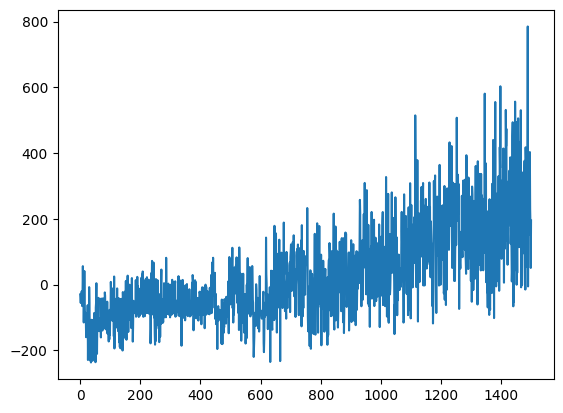

In [70]:
plt.plot(model._total_rewards)

In [69]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)

frames = []
scores = 0
s, _ = eval_env.reset()

done, ret = False, 0

while not done:
    frames.append(eval_env.render())
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = torch.argmax(model.actor(s), dim=-1)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
scores += ret

True


In [ ]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

animate(frames, None)